In [22]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import json
import re
from transformers import AutoProcessor, AutoModelForVision2Seq
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig, get_peft_model
from transformers import TrainerCallback, TrainerState, TrainerControl

class CocoDataset(CocoDetection):
    def __init__(self, root, annFile, augments=None, synonyms=None, use_synonyms=False):
        super().__init__(root, annFile)
        self.augments = augments
        self.num_tokens = 256
        self.synonyms = synonyms
        self.use_synonyms = use_synonyms

    def bbox_to_tokens(self,bbox,img_width,img_height):
        """
        (x,y,w,h) -> token[y_min, x_min, y_max, x_max]
        """
        x,y,w,h = bbox
        x_min = int(round((x / img_width) * (self.num_tokens-1)))
        x_max = int(round(((x+w) / img_width) * (self.num_tokens-1)))
        y_min = int(round((y / img_height) * (self.num_tokens-1)))
        y_max = int(round(((y+h) / img_height) * (self.num_tokens-1)))

        bbox = [y_min,x_min,y_max,x_max]

        assert not any(v>self.num_tokens-1 or v<0 for v in bbox), f'incorrect calculation: {bbox}'

        return [f"<loc{v:03d}>" for v in bbox]

    def tokens_to_bbox(self,tokens,img_width,img_height):
        """
        token[y_min, x_min, y_max, x_max] -> (x,y,w,h)
        """
        y_min, x_min, y_max, x_max = [int(re.search(r"\d+", t).group()) for t in tokens]

        assert not any(v>self.num_tokens-1 or v<0 for v in [y_min, x_min, y_max, x_max]), f'incorrect tokens: {tokens}'

        x_min = (x_min / (self.num_tokens-1)) * img_width
        y_min = (y_min / (self.num_tokens-1)) * img_height
        x_max = (x_max / (self.num_tokens-1)) * img_width
        y_max = (y_max / (self.num_tokens-1)) * img_height

        bbox = [round(x_min,2), round(y_min,2), round(x_max-x_min, 2), round(y_max-y_min,2)]
        return bbox


    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        image_np = np.array(image)

        bboxes = [obj['bbox'] for obj in target]
        category_ids = [obj['category_id'] for obj in target]

        augmented = self.augments(
            image=image_np,
            bboxes=bboxes,
            category_ids=category_ids
        )
        image = augmented['image']
        bboxes = augmented['bboxes']
        category_ids = augmented['category_ids']

        chosen_synonyms = {k:random.choice(v) if self.use_synonyms else v[0] for k,v in self.synonyms.items()}

        targets = dict()
        img_width, img_height = 512,512

        for i, bbox in enumerate(bboxes):
            tokens = self.bbox_to_tokens(bbox, img_width, img_height)
            category_label = chosen_synonyms[category_ids[i]]
            if targets.get(category_label,None) is None:
                targets[category_label] = list()
            targets[category_label].append(''.join(tokens))
        texts = []
        for label, tokens in targets.items():
            label_texts = '\n'.join([f"{obj_tokens} {label};" for obj_tokens in tokens]).strip()
            texts.append(label_texts)

        text = '\n'.join(texts).strip() if len(texts) > 0 else 'no objects detected'

        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": f"detect {'; '.join(targets.keys()).strip()}".strip()}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": text}
                ]
            },
        ]

        return {
            'messages': conversation,
            'image': image,
            'bboxes': bboxes
        }


base_path = Path('/data2/shreyas/datasets/coco/coco2017')
ds_info = {
    'train': {
        'dir': base_path / 'train2017',
        'annotation': base_path / 'annotations' / 'instances_train2017.json'
    },
    'val': {
        'dir': base_path / 'val2017',
        'annotation': base_path / 'annotations' / 'instances_val2017.json'
    }
}


with open(base_path/'categories.json') as f:
    category_synonyms = json.load(f)
    category_synonyms = {int(k):v for k,v in category_synonyms.items()}


train_tfms = A.Compose([
    A.Resize(height=640,width=640),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=15,
        p=0.3,
        border_mode=0
    ),
    A.AtLeastOneBBoxRandomCrop(height=512, width=512, erosion_factor=0.2, p=1.0),
    A.HorizontalFlip(p=0.5),

], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids'], filter_invalid_bboxes=True, min_area=35000))

new_tokens = [f'<loc{v:03d}>' for v in range(256)]
print(len(new_tokens), new_tokens[:5])

256 ['<loc000>', '<loc001>', '<loc002>', '<loc003>', '<loc004>']


In [23]:

train_ds = CocoDataset(
    root=ds_info['train']['dir'],
    annFile=ds_info['train']['annotation'],
    augments=train_tfms,
    synonyms=category_synonyms
)


loading annotations into memory...
Done (t=15.30s)
creating index...
index created!


In [24]:
x = train_ds[500]

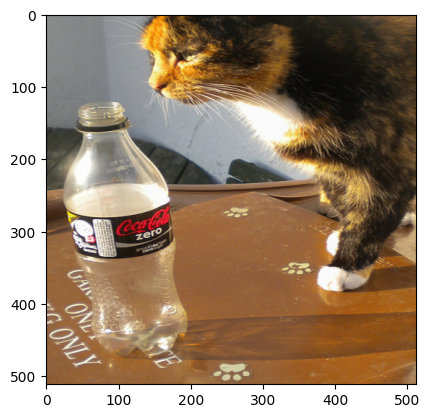

In [25]:
plt.imshow(x['image'])

In [26]:
x['messages']

[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text', 'text': 'detect cat; bottle'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': '<loc000><loc058><loc192><loc255> cat;\n<loc059><loc013><loc237><loc101> bottle;'}]}]

In [27]:
'<loc000>,<loc058>,<loc192>,<loc255>'.split(',')

['<loc000>', '<loc058>', '<loc192>', '<loc255>']

In [30]:
b1 = train_ds.tokens_to_bbox('<loc000>,<loc058>,<loc192>,<loc255>'.split(','),512,512)
b1

[116.45, 0.0, 395.55, 385.51]

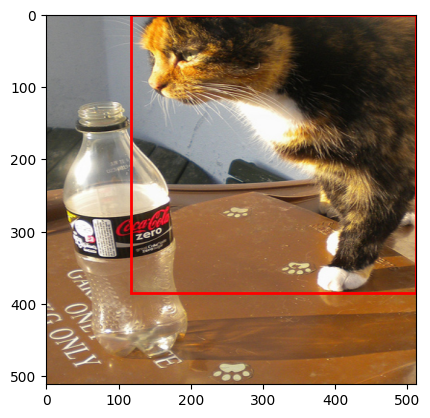

In [33]:
fig,ax = plt.subplots(1,1)
ax.imshow(x['image'])
rect = patches.Rectangle((b1[0],b1[1]),b1[2],b1[3],linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()